# Gathering and preprocessing



In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import colorsys

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



#### Combine the data

In [9]:
files = [file for file in os.listdir("./LGA_data") if file.endswith(".xls")]
all_files = pd.DataFrame()

for file in files:
    df = pd.read_excel("./LGA_data/" + file)
    all_files = pd.concat([all_files, df])

/var/folders/1c/xdsm7htj4334pn2n9vx5kz900000gn/T/ipykernel_35213/912865602.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_files = pd.concat([all_files, df])


#### Clean the data

In [10]:
num_rows = all_files.shape[0]
print("Number of rows before cleaning:", num_rows)
all_files.dropna(subset=['Street Display'], inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping NAs:", num_rows)
all_files.drop_duplicates(inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping duplicates:", num_rows)
# Find the indices of the rows with sale price equal to 0
indices_to_drop = all_files[all_files['Sale Price'] == 0].index
# Drop the rows from the dataset
all_files.drop(indices_to_drop, inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping obs with sales price = 0:", num_rows)


Number of rows before cleaning: 874193
Number of rows after dropping NAs: 873680
Number of rows after dropping duplicates: 873610
Number of rows after dropping obs with sales price = 0: 526056


In [11]:
all_files = all_files.reset_index(drop=True)
df = all_files
# df.to_csv('alldata.csv', index=False)

#### Check the data

In [ ]:
# Check if all LGAs have sale data from 1/7/2018 to 1/7/2023
# oldest_sale_dates = df.groupby('LGA')['Sale Date'].min()
# print(oldest_sale_dates)
# oldest_sale_dates.to_csv('oldest_sale_dates.csv')

When downloading the data, I noticed that there would be a maximum of 10,000 observations downloaded for each LGA. I want to investigate whether there is a gap of sales data in those LGAs from 01/07/2018 to 01/07/2023. I will need to download more data for these LGAs. Below I find at what date I should re-download data.

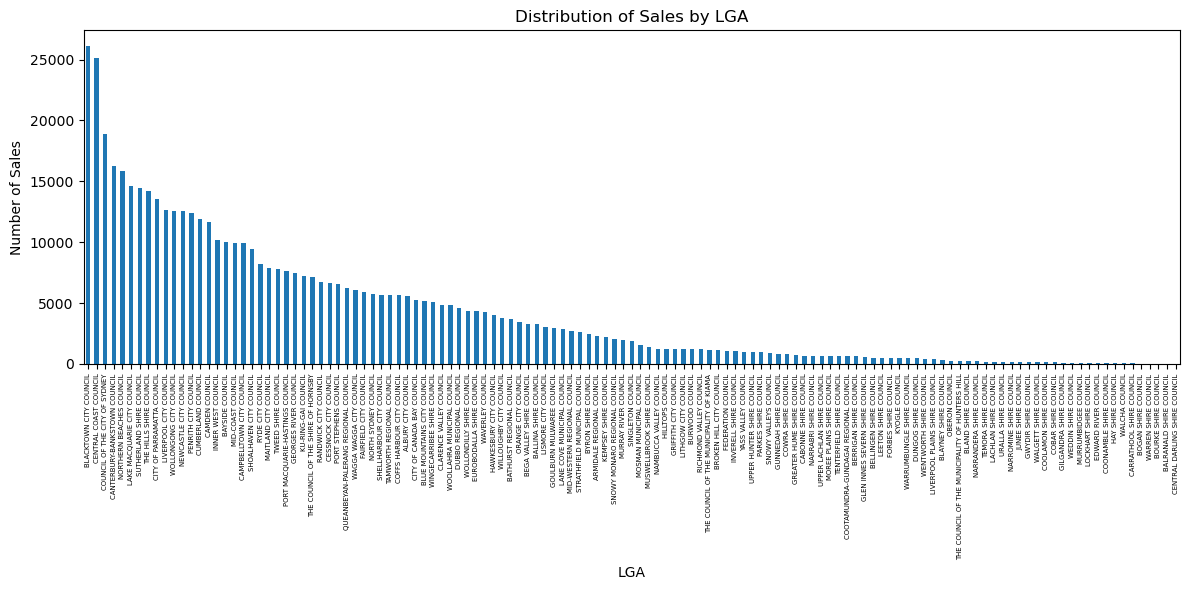

LGAs with 10,000 sales, latest sale dates, and Street Display:


In [ ]:
# Group the data by LGA and count the number of sales
sales_count_by_lga = df['LGA'].value_counts()

# Plot the distribution graph
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sales_count_by_lga.plot(kind='bar')
plt.xlabel('LGA')
plt.ylabel('Number of Sales')
plt.title('Distribution of Sales by LGA')
plt.xticks(rotation=90, fontsize=5)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust the layout
plt.show()

# Filter LGAs with 10,000 sales
lgas_with_10000_sales = sales_count_by_lga[sales_count_by_lga == 10000]

# Print the names of LGAs with 10,000 sales
print("LGAs with 10,000 sales, latest sale dates, and Street Display:")
for lga in lgas_with_10000_sales.index:
    lga_data = df[df['LGA'] == lga]
    latest_sale_date = lga_data['Sale Date'].max()
    latest_sale_street_display = lga_data.loc[lga_data['Sale Date'] == latest_sale_date, 'Street Display'].iloc[0]
    print(f"LGA: {lga}, Latest Sale Date: {latest_sale_date}, Street Display: {latest_sale_street_display}")

In [ ]:
# lga_specific_sales = df[df['LGA'] == 'RYDE CITY COUNCIL']
# lga_specific_sales.head(30)


Now I'll check to see if the data looks right and makes sense

In [12]:
df.columns

Index(['Disclaimer', 'Building Name', 'Street Display',
       'Alternate Street Display', 'Other', 'Unit', 'Number', 'Street Name',
       'Locality', 'Postcode', 'Alt. Street', 'Alt. Locality',
       'Legal Description', 'Volume/Folio', 'Vendor Names', 'Vendor Address',
       'Purchaser Names', 'Purchaser Address', 'Volume Folio', 'Parish',
       'Office Name', 'Agent Name', 'First Price', 'Change %', 'Last Price',
       'Change %.1', 'Days To Sell', 'Sale Price', 'Sale Date',
       'Settlement Date', 'Sale Type', 'Area', 'Building Area', 'Bedrooms',
       'Bathrooms', 'Car Parks', 'Property Type', 'Land Use', 'Zoning',
       'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type',
       'Roof Type', 'Improvements', 'Hundred', 'Sale Category',
       'Document Status', 'Parties Related Flag', 'Parties Related',
       'Valuation Date', 'Valuation Amount', 'LGA', 'Dealing Number',
       'Government Number', 'Parent Government Number', 'PDS ID', 'Sale ID',
       

In [13]:
df.dtypes

Disclaimer                          object
Building Name                       object
Street Display                      object
Alternate Street Display           float64
Other                              float64
Unit                               float64
Number                              object
Street Name                         object
Locality                            object
Postcode                           float64
Alt. Street                        float64
Alt. Locality                      float64
Legal Description                   object
Volume/Folio                       float64
Vendor Names                        object
Vendor Address                      object
Purchaser Names                     object
Purchaser Address                   object
Volume Folio                       float64
Parish                             float64
Office Name                         object
Agent Name                          object
First Price                         object
Change %   

In [14]:
# Calculate summary statistics for numeric columns
summary_stats = df[['Sale Price', 'Area', 'Bedrooms', 'Bathrooms', 'Car Parks']].describe()

# Print the summary statistics
print(summary_stats)


         Sale Price          Area       Bedrooms      Bathrooms      Car Parks
count  5.260560e+05  5.029530e+05  392689.000000  392470.000000  374149.000000
mean   1.096319e+06  4.918656e+04       3.159192       1.737521       1.968459
std    4.943911e+06  1.511399e+06       1.515466       1.588563       4.474361
min    1.000000e+03  7.892128e-01       0.000000       0.000000       0.000000
25%    4.710000e+05  4.201000e+02       2.000000       1.000000       1.000000
50%    7.190000e+05  6.620000e+02       3.000000       2.000000       2.000000
75%    1.125108e+06  1.112597e+03       4.000000       2.000000       2.000000
max    9.459457e+08  4.553400e+08     400.000000     815.000000    1200.000000


Weird that theres a property with 400 bedrooms. Same weirdness with 815 bathrooms and 1619 car parks.

Even more weird that there's a sale for $945M.

# Analysis of general descriptive statistics

### Box and whisker plots

I'll use box and whisker plots to show the mean and interquartile range differences between each LGA

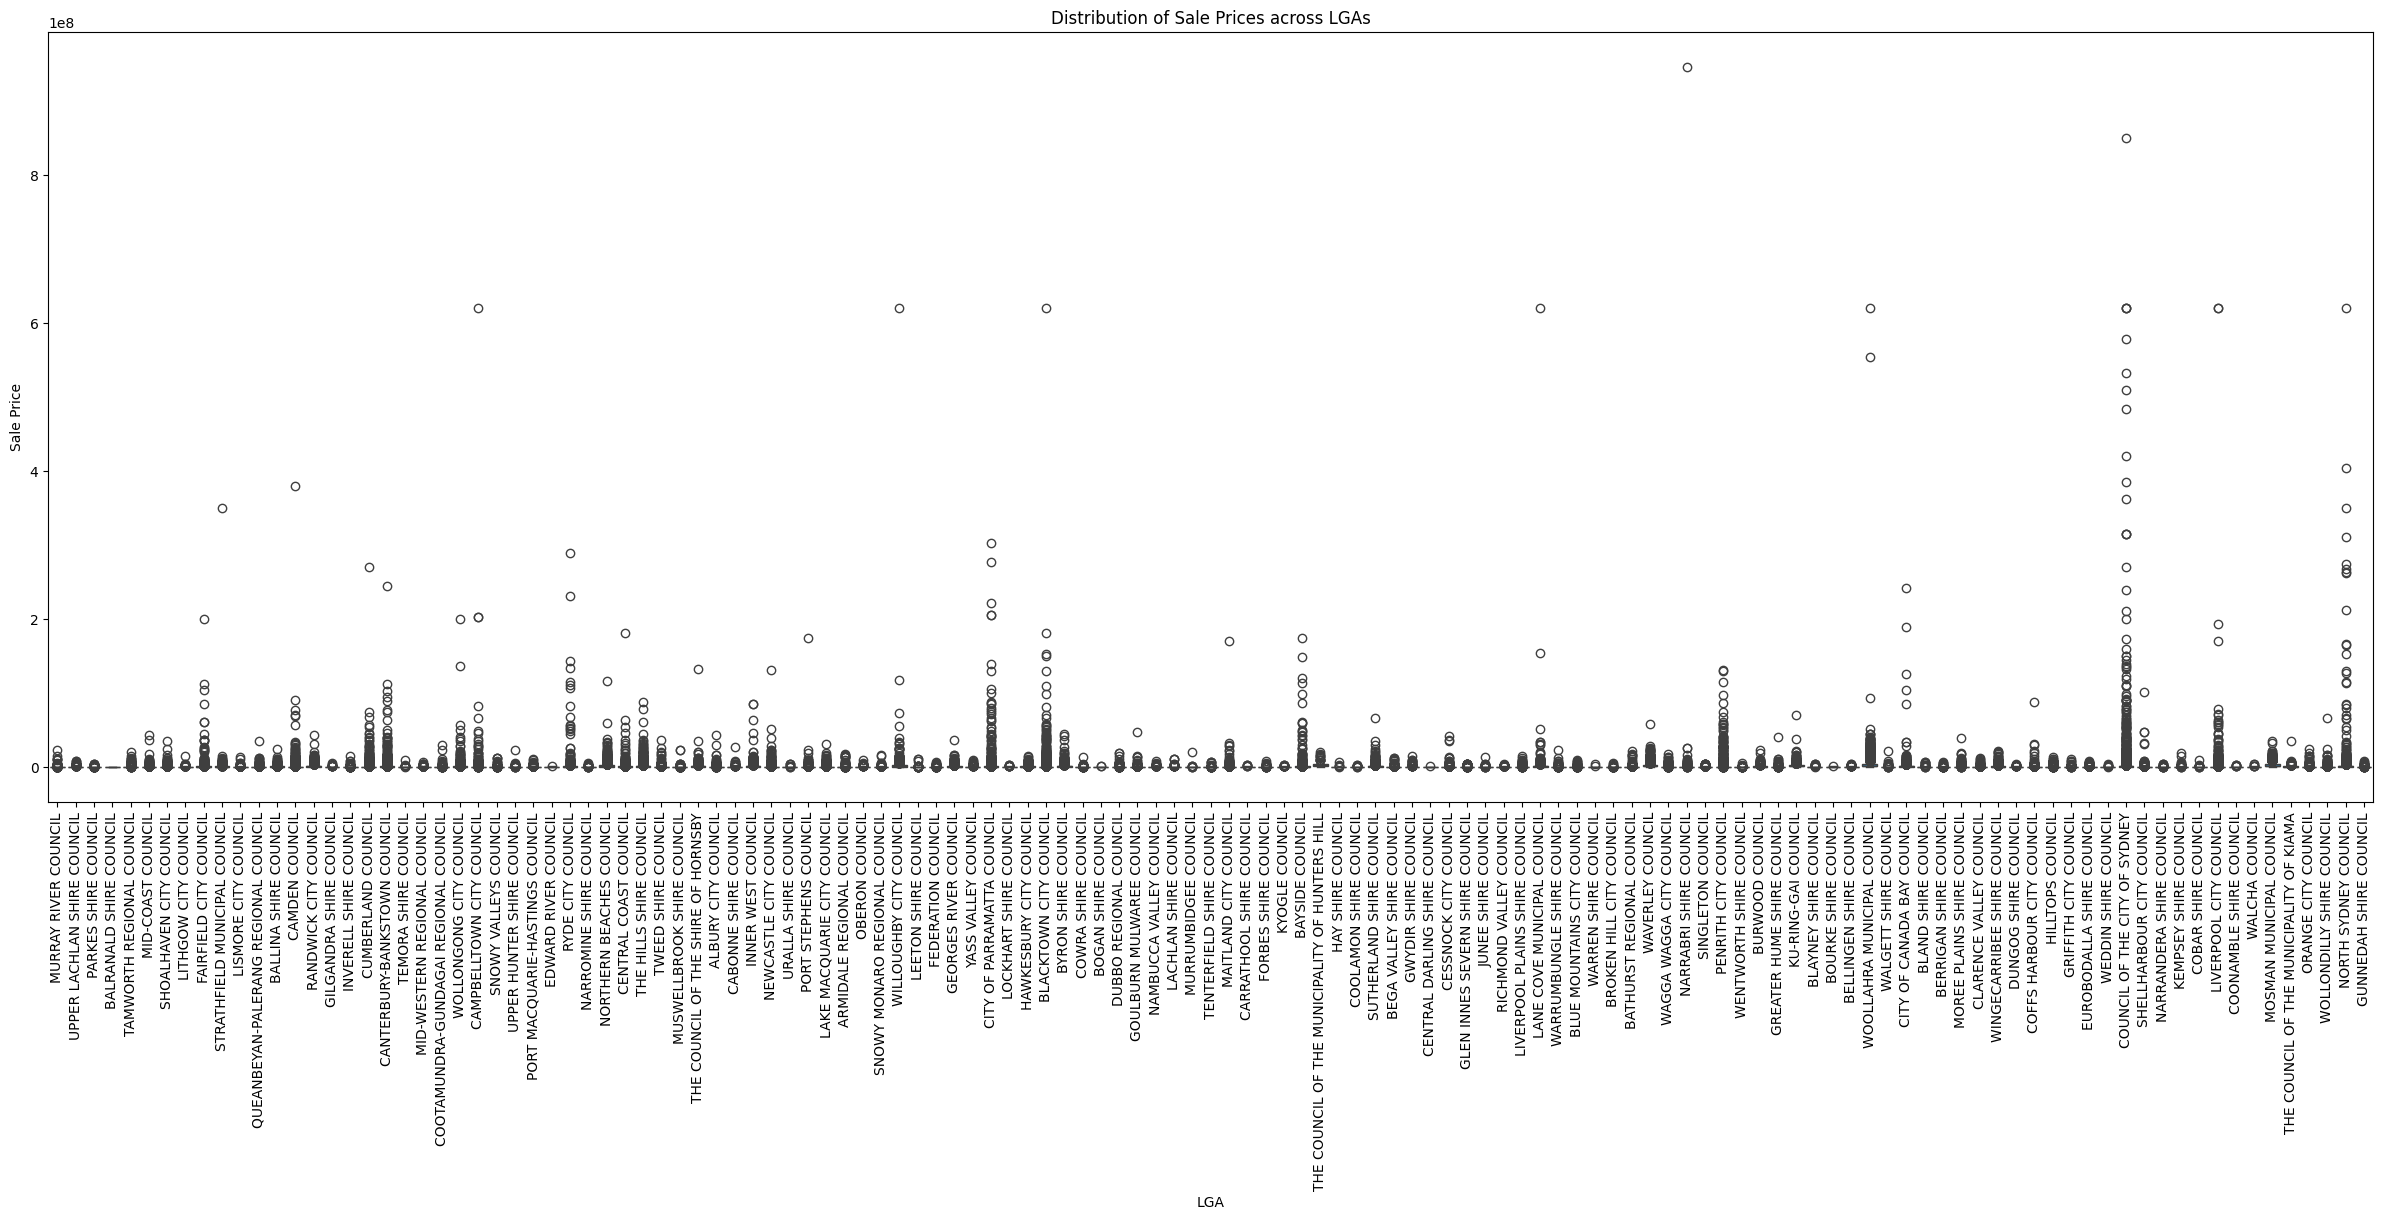

In [15]:
plt.figure(figsize=(30, 10))
sns.boxplot(x='LGA', y='Sale Price', data=df)
plt.xlabel('LGA')
plt.ylabel('Sale Price')
plt.title('Distribution of Sale Prices across LGAs')
plt.xticks(rotation=90)
plt.show()

Filtering to values below $5M to minimise outliers

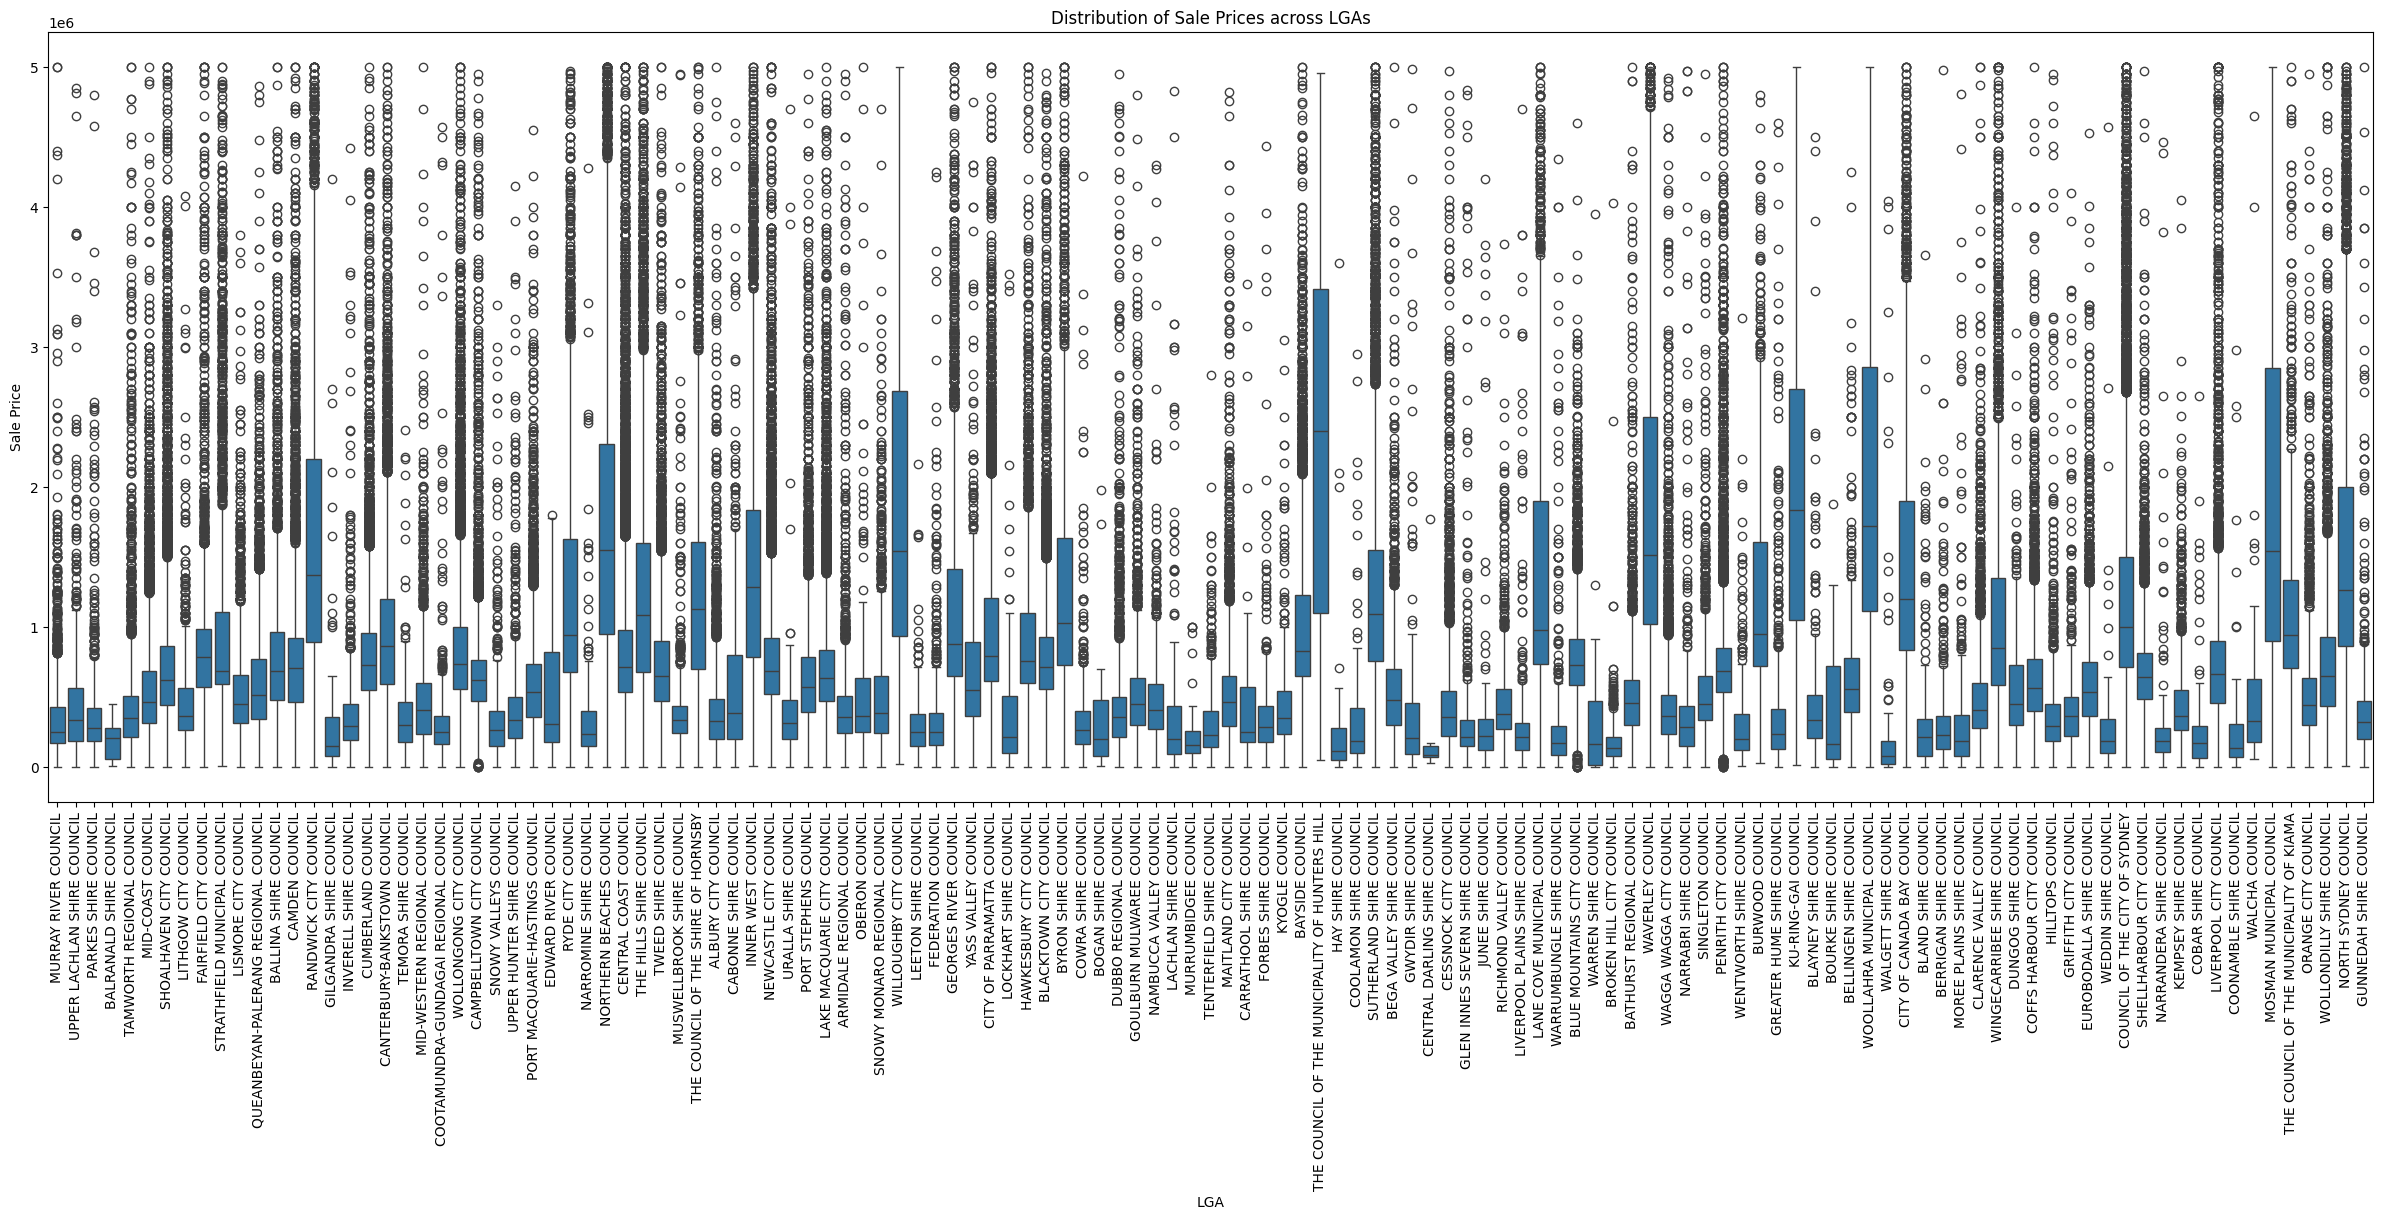

In [16]:
df_lessthan5M = df[df['Sale Price'] <= 5000000]

plt.figure(figsize=(30, 10))
sns.boxplot(x='LGA', y='Sale Price', data=df_lessthan5M)
plt.xlabel('LGA')
plt.ylabel('Sale Price')
plt.title('Distribution of Sale Prices across LGAs')
plt.xticks(rotation=90)
plt.show()

Narrowing down results to sales in the past 365 days (01/07/2022 - 01/07/2023)

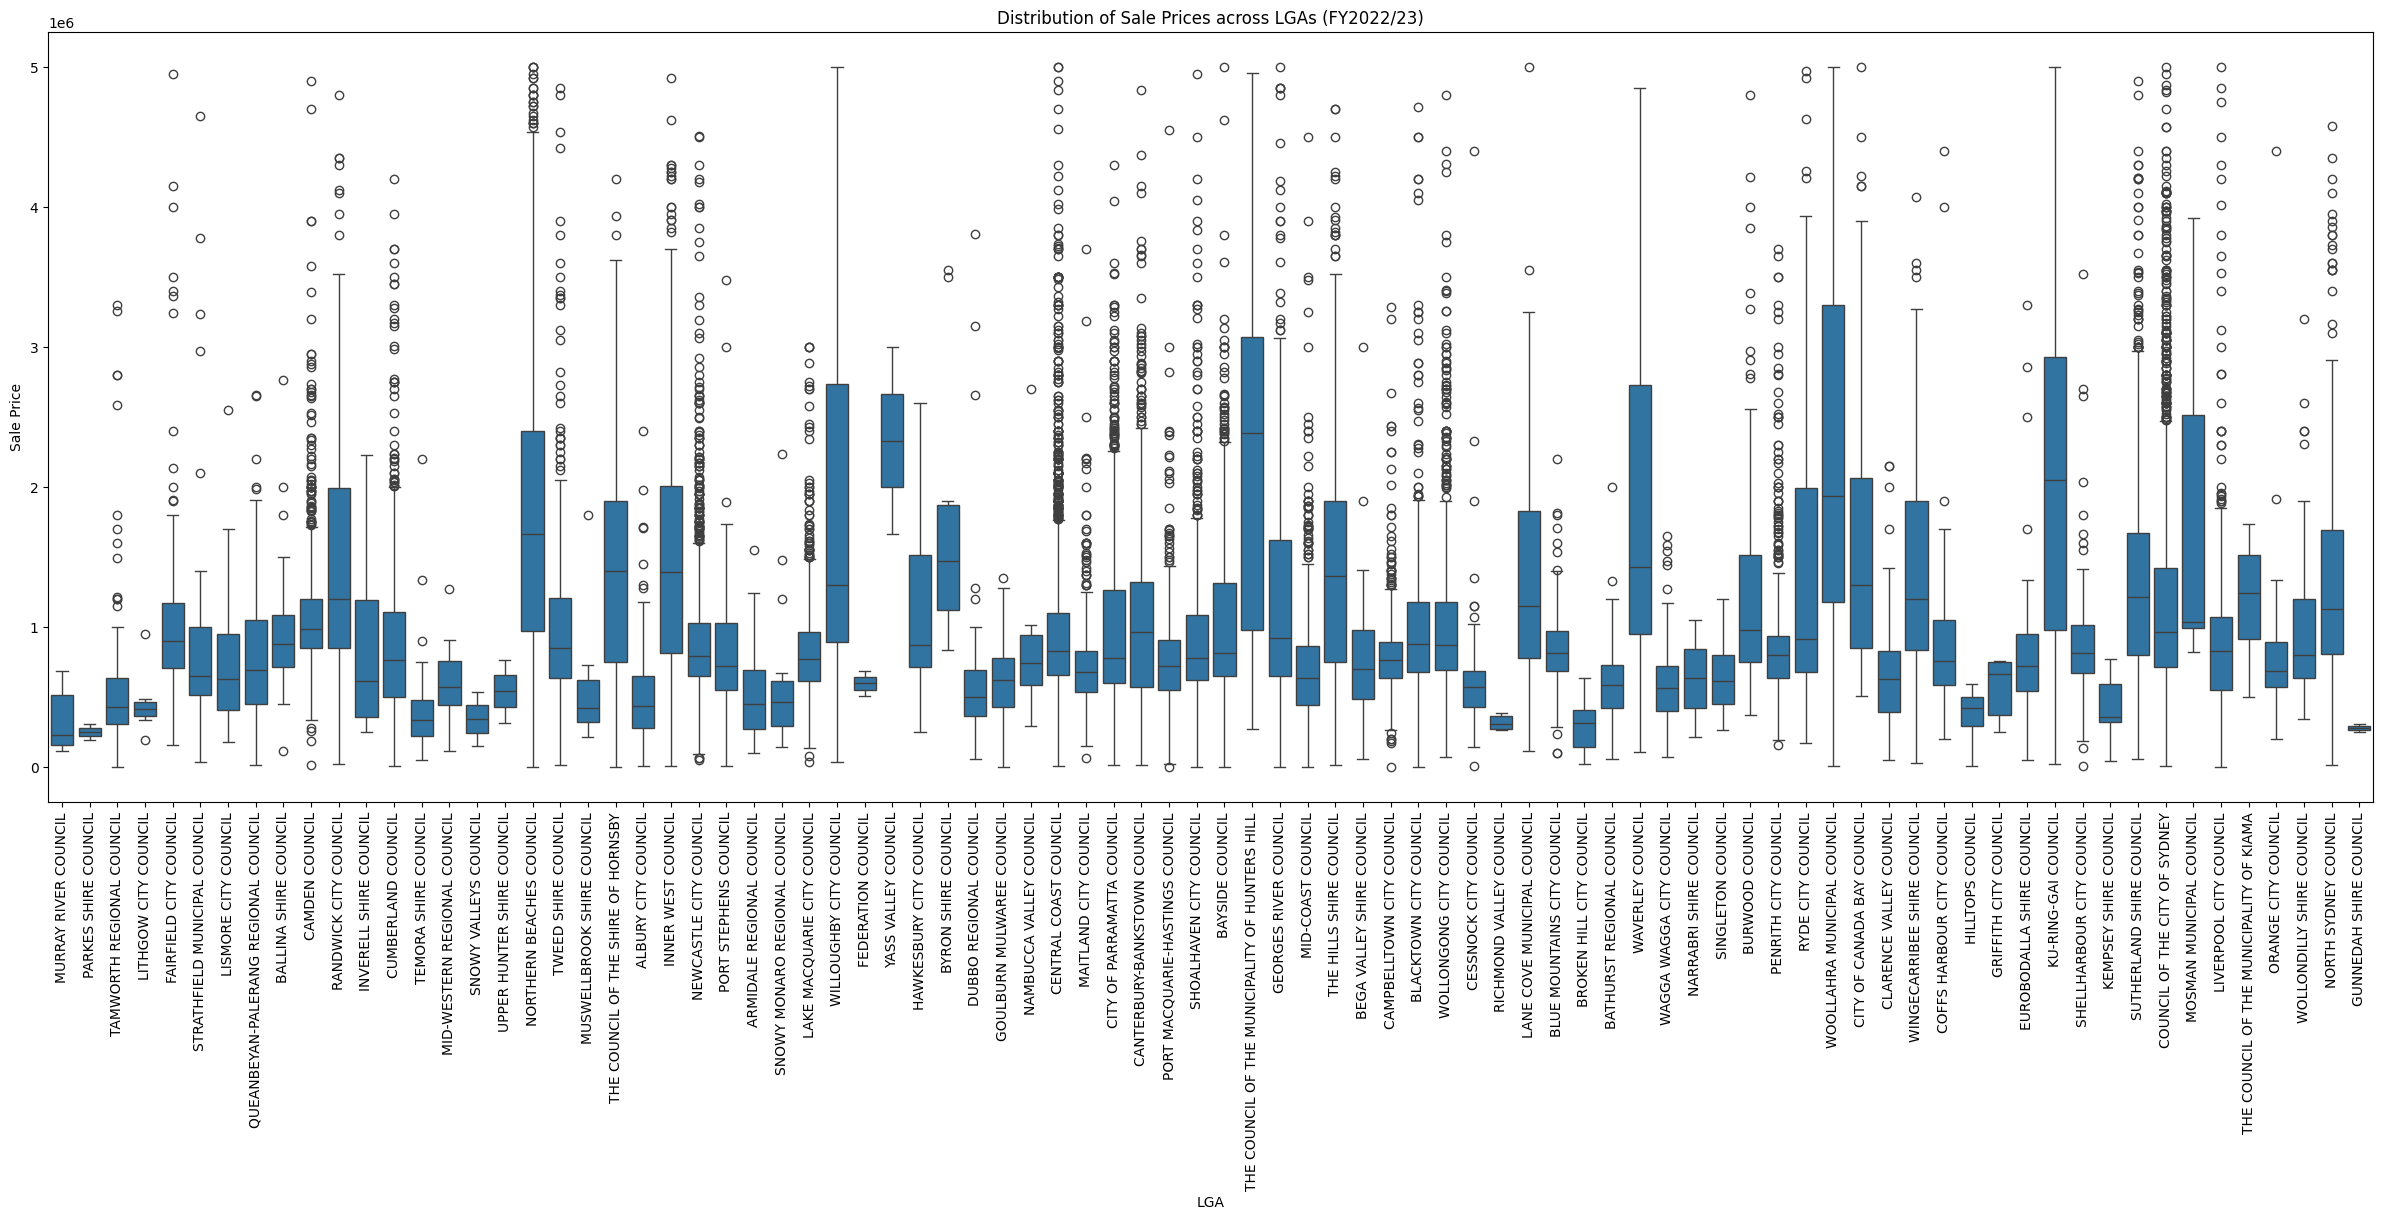

In [17]:
# Filter the DataFrame for sales in the past year
one_year_ago = datetime.now() - timedelta(days=365)
df_oneYearAgo_lessthan5M = df_lessthan5M[df_lessthan5M['Sale Date'] >= one_year_ago]

plt.figure(figsize=(30, 10))
sns.boxplot(x='LGA', y='Sale Price', data=df_oneYearAgo_lessthan5M)
plt.xlabel('LGA')
plt.ylabel('Sale Price')
plt.title('Distribution of Sale Prices across LGAs (FY2022/23)')
plt.xticks(rotation=90)
plt.show()

#### Discussion

* Wealthier LGAs often have greater interquartile ranges, whereas poorer LGAs have tight bands
* The majority of LGAs still have their sale price averages below $1M
* The lack of outliers below the interquartile range shows how tight the housing market is; there is no room to catch a bargain

### Distribution plots

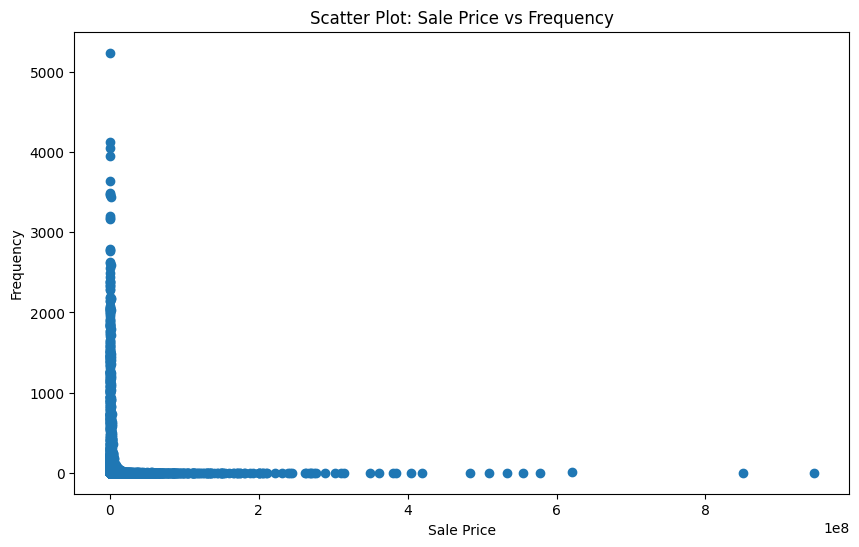

In [18]:
# Calculate the frequency of each sales price value
sales_price_counts = df['Sale Price'].value_counts()

# Extract the sales prices and their frequencies
sales_prices = sales_price_counts.index
frequencies = sales_price_counts.values

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sales_prices, frequencies)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Scatter Plot: Sale Price vs Frequency')
plt.show()

I'll need to filter the data so that the sales on the far right hand side of the above scatter plot do not heavily skew my graphs. I'll filter the results to only include sales of $10M or less as the scatter plot visually looks more interesting and is of greater relevance to normal home buyers (like myself).

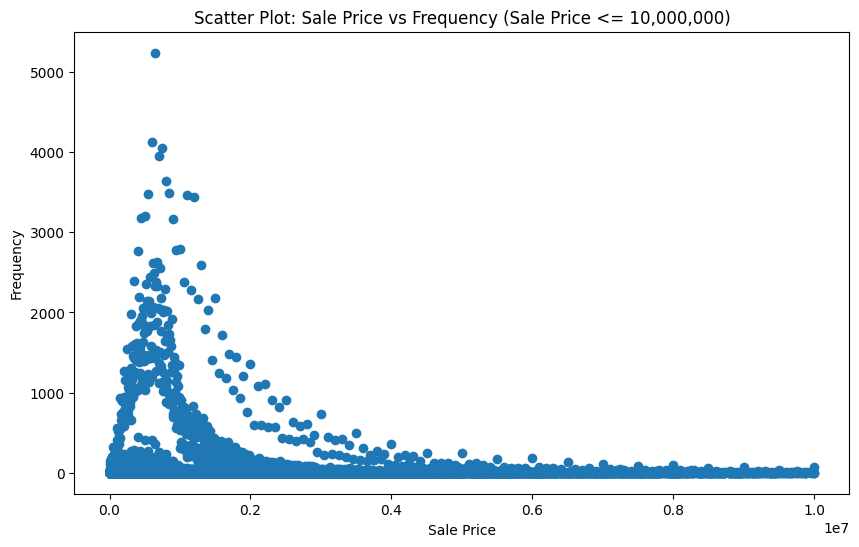

In [19]:
# Filter the DataFrame based on the sale price condition
df_lessthan10M = df[df['Sale Price'] <= 10000000]

# Calculate the frequency of each sales price value in the filtered DataFrame
sales_price_counts = df_lessthan10M['Sale Price'].value_counts()

# Extract the sales prices and their frequencies
sales_prices = sales_price_counts.index
frequencies = sales_price_counts.values

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sales_prices, frequencies)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Scatter Plot: Sale Price vs Frequency (Sale Price <= 10,000,000)')
plt.show()

Now to plot a histogram, I will further narrow down analysis to sales upto $4M as this visually seems to be the point where there is no variation in the frequency of sales occuring at price points beyond $4M. This gives us a much more meaningful histogram below.

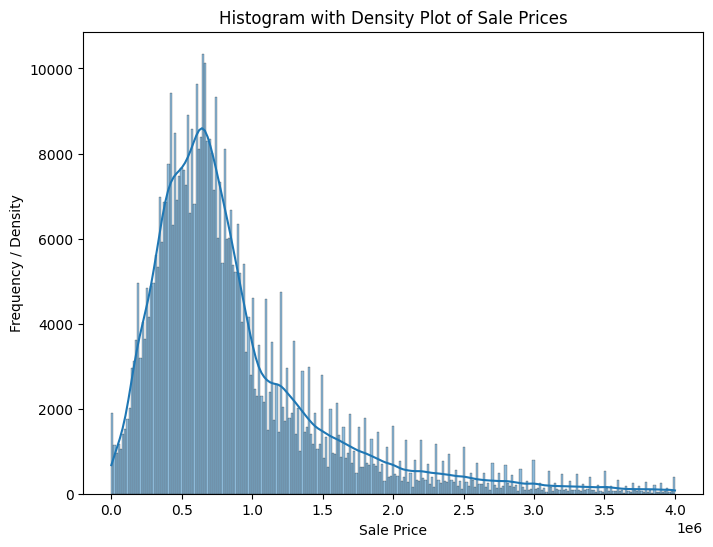

In [20]:
df_lessthan4M = df[df['Sale Price'] <= 4000000]

plt.figure(figsize=(8, 6))
sns.histplot(df_lessthan4M['Sale Price'], kde=True)
plt.xlabel('Sale Price')
plt.ylabel('Frequency / Density')
plt.title('Histogram with Density Plot of Sale Prices')
plt.show()


Now to plot the differences from 2018 to 2023

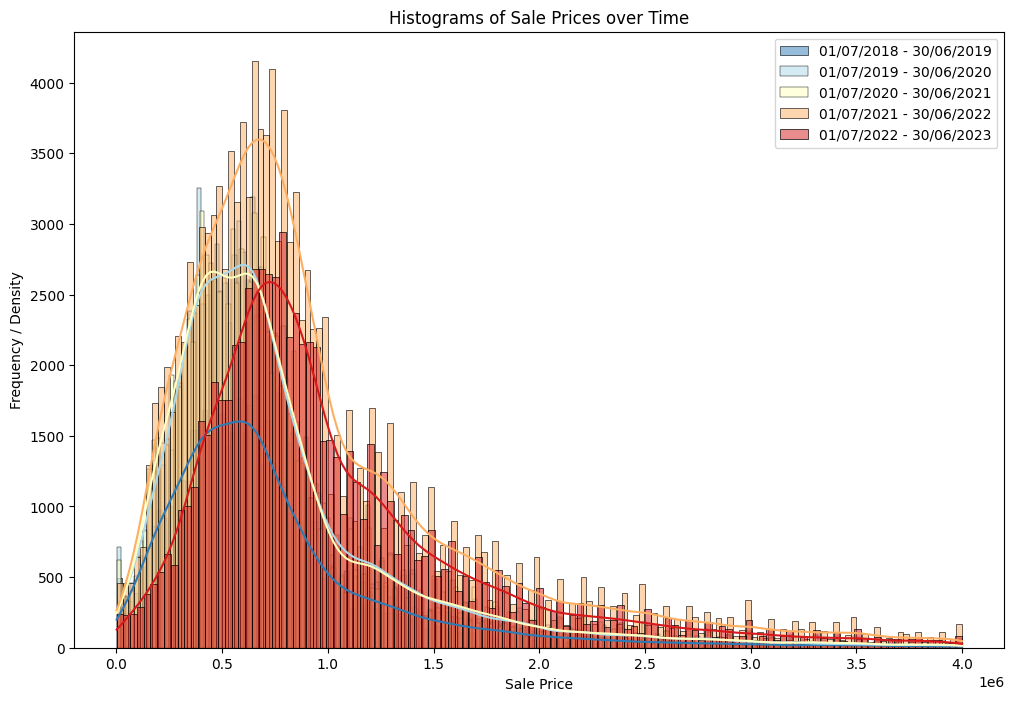

In [21]:
# Define the time periods with date ranges
time_periods = [
    '01/07/2018 - 30/06/2019',
    '01/07/2019 - 30/06/2020',
    '01/07/2020 - 30/06/2021',
    '01/07/2021 - 30/06/2022',
    '01/07/2022 - 30/06/2023'
]

colours = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']

# Create a list to store the filtered data for each time period
filtered_data_list_histogram = []

# Iterate over time periods
for i, time_period in enumerate(time_periods):
    # Extract start and end dates
    start_date = pd.to_datetime('01/07/2018') + pd.DateOffset(years=i)
    end_date = start_date + pd.DateOffset(years=1) - pd.DateOffset(days=1)
    
    # Filter the data for the specific time period
    filtered_data = df_lessthan4M[(df_lessthan4M['Sale Date'] >= start_date) & (df_lessthan4M['Sale Date'] <= end_date)]
    
    filtered_data_list_histogram.append(filtered_data)

# Create the overlaid histograms
plt.figure(figsize=(12, 8))
for i, filtered_data in enumerate(filtered_data_list_histogram):
    sns.histplot(filtered_data['Sale Price'], label=time_periods[i], kde=True, alpha=0.5, color=colours[i])

plt.xlabel('Sale Price')
plt.ylabel('Frequency / Density')
plt.title('Histograms of Sale Prices over Time')
plt.legend()
plt.show()


Remember that the height of this plot is the frequency of sales.

#### Discussion

* $700k seems to be the average in the NSW market
* Demand for property beyond $2M seems to plateau. At this point, price is no longer an indication of demand, but rather of the intrinsic value of the home to the buyer (or at least this is how I interpret it)
* Average prices began to rise dramatically in FY2021/22 and continued to rise into FY2022/23
* Volume of sales rose from FY2018/19 to FY2019/20 dramatically, bascially stayed the same in the following year, then peaked in FY2021/22, and finally cooled down in FY2022/23 to similar levels in previous years.
* Therefore, despite the market cooling down in 2022/23, prices continued to rise. This must be explained by a lack of supply.

# Analysis for property investing (02.12.2023)

In [24]:
df.head()

,Disclaimer,Building Name,Street Display,Alternate Street Display,Other,Unit,Number,Street Name,Locality,Postcode,Alt. Street,Alt. Locality,Legal Description,Volume/Folio,Vendor Names,Vendor Address,Purchaser Names,Purchaser Address,Volume Folio,Parish,Office Name,Agent Name,First Price,Change %,Last Price,Change %.1,Days To Sell,Sale Price,Sale Date,Settlement Date,Sale Type,Area,Building Area,Bedrooms,Bathrooms,Car Parks,Property Type,Land Use,Zoning,Main Rooms,Build Year,Building Style,Storeys,Wall Type,Roof Type,Improvements,Hundred,Sale Category,Document Status,Parties Related Flag,Parties Related,Valuation Date,Valuation Amount,LGA,Dealing Number,Government Number,Parent Government Number,PDS ID,Sale ID,Load Date,Property ID
0,NaN,NaN,24 MORAGO ST,NaN,NaN,NaN,24,MORAGO ST,MOULAMEIN,2733.0,NaN,NaN,9/4/DP758713,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,2023-02-07,2023-02-07,Agents Advice - Sale,1012.00,NaN,3.0,1.0,1.0,Commercial,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,24300.0,MURRAY RIVER COUNCIL,NaN,NSW572440,NaN,2.447154e+07,81038106.0,2023-02-08 15:12:31.669,NaN
1,NaN,JAKABRESUE,191 DAHWILLY RD,NaN,NaN,NaN,191,DAHWILLY RD,DENILIQUIN,2710.0,NaN,NaN,4/130/758782,NaN,HILLIER,"DAHWILLY RD, DENILIQUIN, NSW, 2710",HILLIER,"DAHWILLY RD, DENILIQUIN, NSW, 2710",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153000.0,2023-02-06,2023-04-05,Normal Sale,60700.00,NaN,NaN,NaN,NaN,Vacant Land,VACANT LAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,157000.0,MURRAY RIVER COUNCIL,AS988184,NSW522024,NaN,1.974438e+07,81634354.0,2023-04-17 11:41:02.151,NaN
2,NaN,NaN,TWENTY FOUR LN,NaN,NaN,NaN,NaN,TWENTY FOUR LANE LN,MOAMA,2731.0,NaN,NaN,243/751159,NaN,EDDY,"TWENTY FOUR LANE, MOAMA, NSW, 2731",TATALIA FARMS PTY LTD,"TWENTY FOUR LANE, MOAMA, NSW, 2731",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600000.0,2022-12-19,2022-12-22,Normal Sale,87670.00,NaN,NaN,NaN,NaN,Vacant Land,VACANT LAND,RU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,654000.0,MURRAY RIVER COUNCIL,AS753576,NSW4372817,NaN,1.513062e+09,80688052.0,2022-12-29 14:59:06.211,NaN
3,NaN,NaN,1 MCMAHON PL,NaN,NaN,NaN,1,MCMAHON PL,MOAMA,2731.0,NaN,NaN,5/805929,NaN,KINDRED; THORP,"1 MCMAHON PL, MOAMA, NSW, 2731",RIO,"1 MCMAHON PL, MOAMA, NSW, 2731",NaN,NaN,Charles L King First National Echuca,Rowena Ash,"Price Guide $665,000 - $685,000",0.0,"Price Guide $665,000 - $685,000",0.0,16.0,688000.0,2022-12-14,2023-02-13,Normal Sale,708.00,NaN,3.0,2.0,2.0,House,RESIDENCE,R1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,224000.0,MURRAY RIVER COUNCIL,AS854804,NSW545591,NaN,2.431793e+06,81101149.0,2023-02-20 11:08:14.053,NaN
4,NaN,NaN,15/314 PERRICOOTA RD,NaN,NaN,NaN,314,PERRICOOTA RD,MOAMA,2731.0,NaN,NaN,26/SP70008,NaN,BRITTON,"15/314 PERRICOOTA RD, MOAMA, NSW, 2731",CCG PLOUGHMANS PTY LTD,"15/314 PERRICOOTA RD, MOAMA, NSW, 2731",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180000.0,2022-12-08,2022-12-20,Normal Sale,52597.91,NaN,NaN,NaN,NaN,Unit,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,MURRAY RIVER COUNCIL,AS746298,NSW546709/26,NaN,1.513418e+09,80688032.0,2022-12-29 14:59:06.209,NaN


### Getting the mean and median prices of each locality for houses only

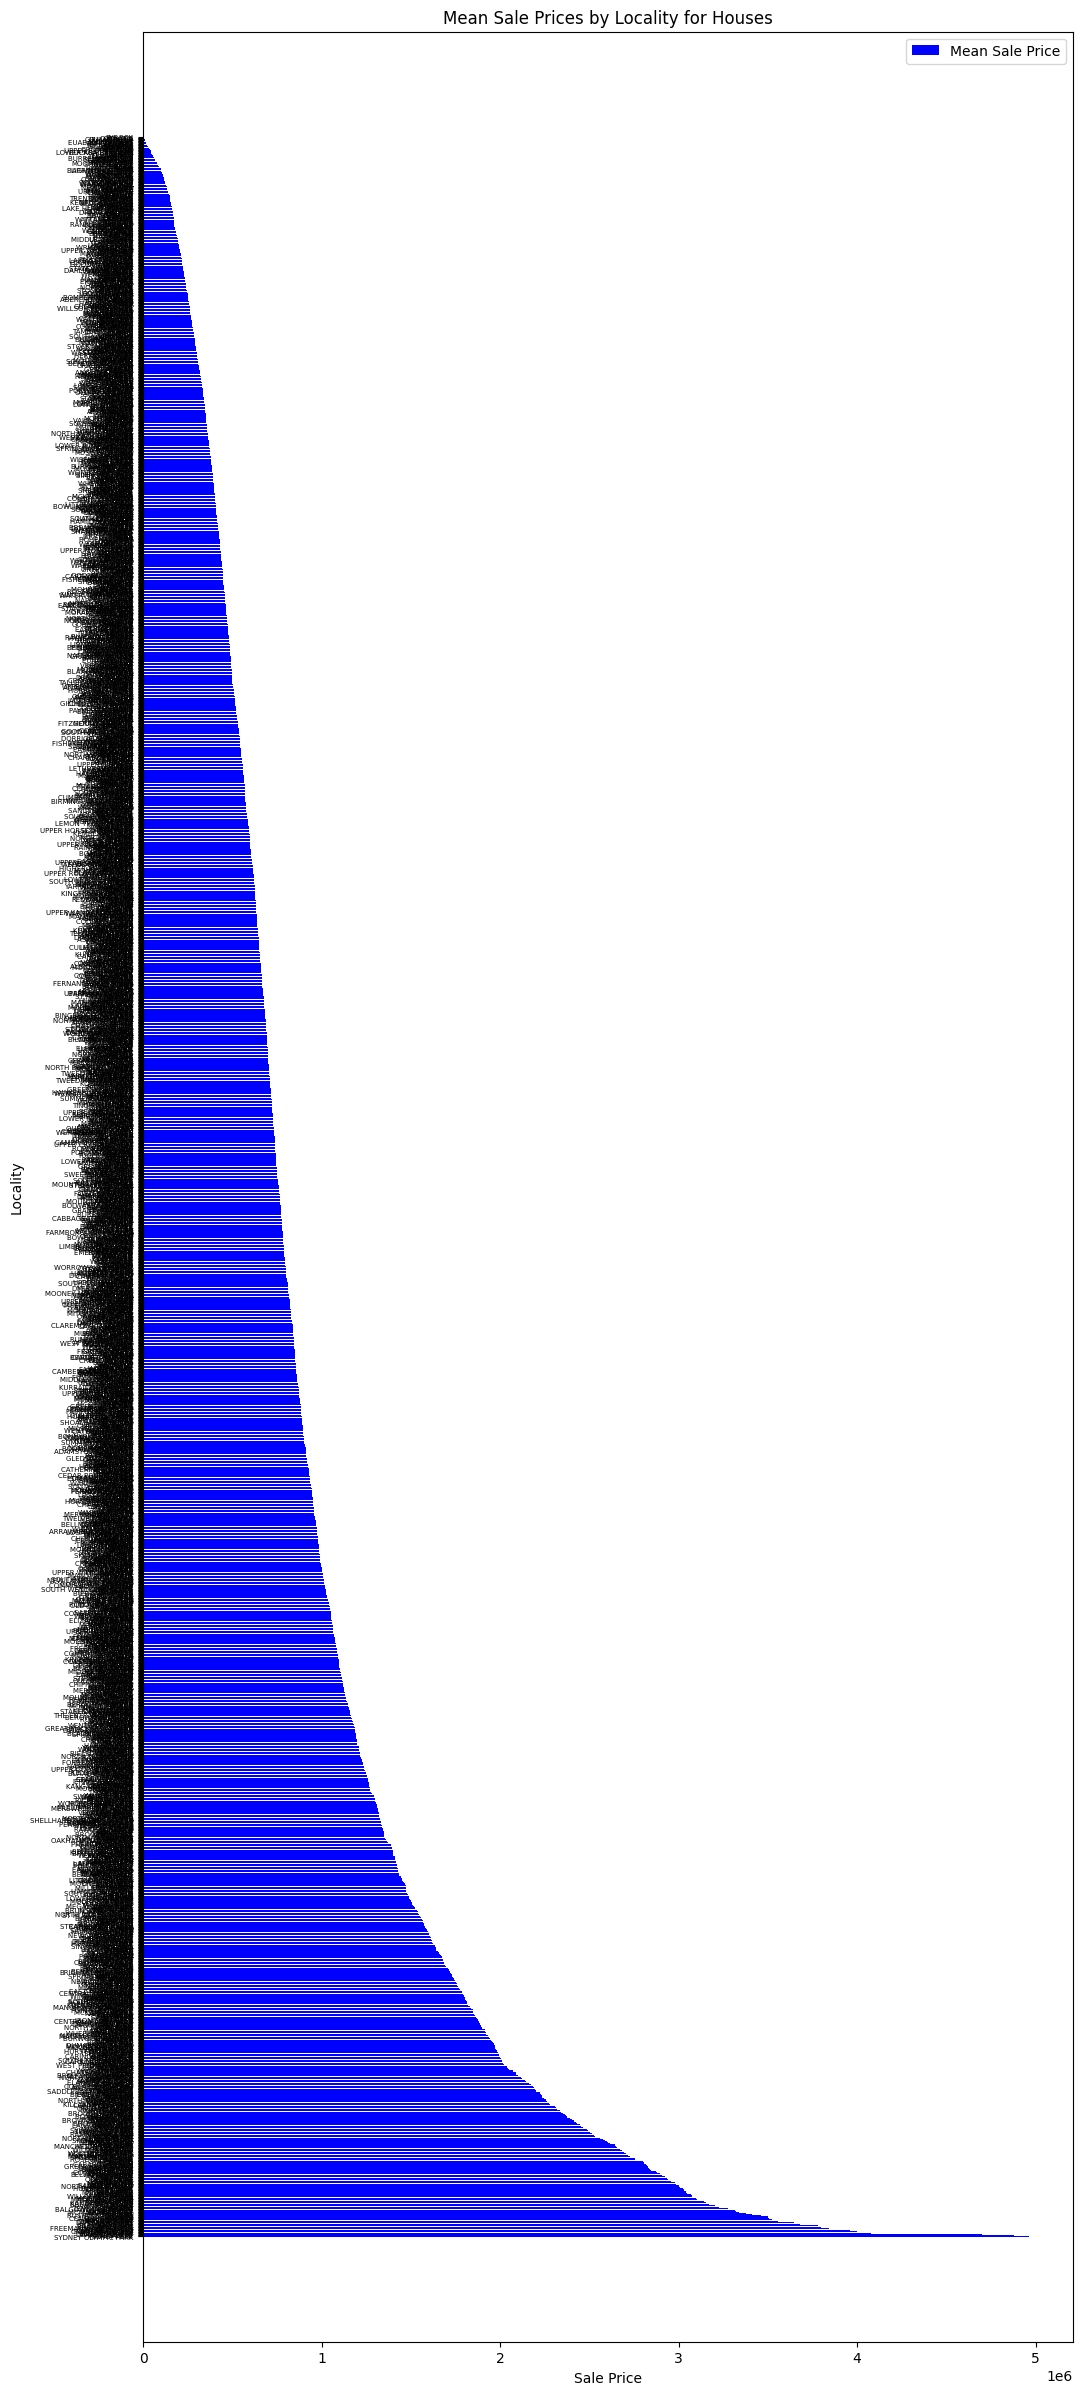

In [29]:
# Filter data for property type 'House' and price <= 5M
df_lessthan5M = df[df['Sale Price'] <= 5000000]
house_data = df_lessthan5M[df_lessthan5M['Property Type'] == 'House']

# Group by 'Locality' and calculate mean and median sale prices
grouped_data = house_data.groupby('Locality')['Sale Price'].agg(['mean', 'median'])





#### Filtering the data

There are way too many localities. I want to positively weight properties that are closer to the Sydney CBD. Therefore, I want to add a column that has the property's distance from the CBD.

(during this process i had immense difficulty with SSL certificate errors. It ended up working by:
1. Pip install certifi
2. /Applications/Python\ 3.11/Install\ Certificates.command)

In [61]:
len(df)

526056

We'll have to request data from Noninatim 526056 times to apply a lat and long to each observation. Running the request for 5 observations took 15 seconds (3 seconds for each obs), which means it'll take **438** hours to complete for all observations.

Alternatives are:
1. *Limit the dataset and see how long it would take*

```python
# Filter data for property type 'House' and price <= 5M and Sale Date = the past year
df['Sale Date'] = pd.to_datetime(df['Sale Date'])
df_lessthan5M = df[df['Sale Price'] <= 5000000]
house_data = df_lessthan5M[df_lessthan5M['Property Type'] == 'House']
most_recent_year = df['Sale Date'].dt.year.max()
house_data_recent_year = house_data[house_data['Sale Date'].dt.year == most_recent_year]
len(house_data_recent_year)
```

This still gives us 16715 obs, which would take **14** hours.


2. *Only request the lat and long of each locality, rather than its actual street address, then apply the same lat and long for all properties in the locality*

```python
unique_localities = df['Locality'].unique().tolist()
print(unique_localities)
len(unique_localities)
```

This gives us 3971 localities, which would take **3.3** hours.

3. *Try and find the postcodes near sydney CBD and just pick them manually*

Postcodes in NSW are fucked – there is no interpretable way they are applied as they have been built for the purpose of postage, not location.

In [62]:
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Create a geolocator object
geolocator = Nominatim(user_agent="NSW-property-data-analysis")


# Use the geolocator to get coordinates
location = geolocator.geocode("Sydney, Australia")
print(location.latitude, location.longitude)

# Define a function to get coordinates from an address
def get_coordinates(address):
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    location = geocode(address)
    return (location.latitude, location.longitude) if location else None

# To apply the lat and long to all obs:
# df['Coordinates'] = df['Street Display'].apply(get_coordinates)
# df.head()


-33.8698439 151.2082848


In [ ]:
# Filter data for property type 'House' and price <= 5M and Sale Date = the past year
# df['Sale Date'] = pd.to_datetime(df['Sale Date'])
# df_lessthan5M = df[df['Sale Price'] <= 5000000]
# house_data = df_lessthan5M[df_lessthan5M['Property Type'] == 'House']
# most_recent_year = df['Sale Date'].dt.year.max()
# house_data_recent_year = house_data[house_data['Sale Date'].dt.year == most_recent_year]
# house_data_recent_year.head()
# len(house_data_recent_year)

# Make Locality easier for Nominatim to read
df['Locality'] = df['Locality'] + ", NSW, AUSTRALIA"

# Make a list of unique localities 
unique_localities = df['Locality'].unique().tolist()
# print(unique_localities)
# len(unique_localities)

# Apply the get_coordinates function to the list of unique localities
coordinates_list = list(map(get_coordinates, unique_localities))

# Create a dictionary to map localities to coordinates
locality_coordinates_dict = dict(zip(unique_localities, coordinates_list))

# Map the coordinates back to the main DataFrame
df['Locality Coordinates'] = df['Locality'].map(locality_coordinates_dict)

df.head()


In [ ]:
df.head()
# df.info()

In [85]:
from geopy.distance import geodesic

sydney_coordinates = geolocator.geocode("Sydney, Australia")
sydney_coordinates = (sydney_coordinates.latitude, sydney_coordinates.longitude)

# Function to calculate distance
def calculate_distance(coords):
    if coords:
        return geodesic(sydney_coordinates, coords).kilometers
    else:
        return None

# Apply the calculate_distance function to the 'Coordinates' column
df['Distance to Sydney (km)'] = df['Locality Coordinates'].apply(calculate_distance)

# Display or use the DataFrame with the new 'Distance to Sydney (km)' column
df.head()


,Disclaimer,Building Name,Street Display,Alternate Street Display,Other,Unit,Number,Street Name,Locality,Postcode,Alt. Street,Alt. Locality,Legal Description,Volume/Folio,Vendor Names,Vendor Address,Purchaser Names,Purchaser Address,Volume Folio,Parish,Office Name,Agent Name,First Price,Change %,Last Price,Change %.1,Days To Sell,Sale Price,Sale Date,Settlement Date,Sale Type,Area,Building Area,Bedrooms,Bathrooms,Car Parks,Property Type,Land Use,Zoning,Main Rooms,Build Year,Building Style,Storeys,Wall Type,Roof Type,Improvements,Hundred,Sale Category,Document Status,Parties Related Flag,Parties Related,Valuation Date,Valuation Amount,LGA,Dealing Number,Government Number,Parent Government Number,PDS ID,Sale ID,Load Date,Property ID,Locality Coordinates,Distance to Sydney (km)
0,NaN,NaN,24 MORAGO ST,NaN,NaN,NaN,24,MORAGO ST,"MOULAMEIN, NSW, AUSTRALIA",2733.0,NaN,NaN,9/4/DP758713,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,2023-02-07,2023-02-07,Agents Advice - Sale,1012.00,NaN,3.0,1.0,1.0,Commercial,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,24300.0,MURRAY RIVER COUNCIL,NaN,NSW572440,NaN,2.447154e+07,81038106.0,2023-02-08 15:12:31.669,NaN,"(-35.0885559, 144.0379924)",672.249452
1,NaN,JAKABRESUE,191 DAHWILLY RD,NaN,NaN,NaN,191,DAHWILLY RD,"DENILIQUIN, NSW, AUSTRALIA",2710.0,NaN,NaN,4/130/758782,NaN,HILLIER,"DAHWILLY RD, DENILIQUIN, NSW, 2710",HILLIER,"DAHWILLY RD, DENILIQUIN, NSW, 2710",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153000.0,2023-02-06,2023-04-05,Normal Sale,60700.00,NaN,NaN,NaN,NaN,Vacant Land,VACANT LAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,157000.0,MURRAY RIVER COUNCIL,AS988184,NSW522024,NaN,1.974438e+07,81634354.0,2023-04-17 11:41:02.151,NaN,"(-35.5302183, 144.9597178)",601.261608
2,NaN,NaN,TWENTY FOUR LN,NaN,NaN,NaN,NaN,TWENTY FOUR LANE LN,"MOAMA, NSW, AUSTRALIA",2731.0,NaN,NaN,243/751159,NaN,EDDY,"TWENTY FOUR LANE, MOAMA, NSW, 2731",TATALIA FARMS PTY LTD,"TWENTY FOUR LANE, MOAMA, NSW, 2731",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600000.0,2022-12-19,2022-12-22,Normal Sale,87670.00,NaN,NaN,NaN,NaN,Vacant Land,VACANT LAND,RU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,654000.0,MURRAY RIVER COUNCIL,AS753576,NSW4372817,NaN,1.513062e+09,80688052.0,2022-12-29 14:59:06.211,NaN,"(-36.1054404, 144.758824)",638.768842
3,NaN,NaN,1 MCMAHON PL,NaN,NaN,NaN,1,MCMAHON PL,"MOAMA, NSW, AUSTRALIA",2731.0,NaN,NaN,5/805929,NaN,KINDRED; THORP,"1 MCMAHON PL, MOAMA, NSW, 2731",RIO,"1 MCMAHON PL, MOAMA, NSW, 2731",NaN,NaN,Charles L King First National Echuca,Rowena Ash,"Price Guide $665,000 - $685,000",0.0,"Price Guide $665,000 - $685,000",0.0,16.0,688000.0,2022-12-14,2023-02-13,Normal Sale,708.00,NaN,3.0,2.0,2.0,House,RESIDENCE,R1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,224000.0,MURRAY RIVER COUNCIL,AS854804,NSW545591,NaN,2.431793e+06,81101149.0,2023-02-20 11:08:14.053,NaN,"(-36.1054404, 144.758824)",638.768842
4,NaN,NaN,15/314 PERRICOOTA RD,NaN,NaN,NaN,314,PERRICOOTA RD,"MOAMA, NSW, AUSTRALIA",2731.0,NaN,NaN,26/SP70008,NaN,BRITTON,"15/314 PERRICOOTA RD, MOAMA, NSW, 2731",CCG PLOUGHMANS PTY LTD,"15/314 PERRICOOTA RD, MOAMA, NSW, 2731",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180000.0,2022-12-08,2022-12-20,Normal Sale,52597.91,NaN,NaN,NaN,NaN,Unit,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,MURRAY RIVER COUNCIL,AS746298,NSW546709/26,NaN,1.513418e+09,80688032.0,2022-12-29 14:59:06.209,NaN,"(-36.1054404, 144.758824)",638.768842


In [90]:
# Extract the first 20 unique localities
unique_localities_sample = df['Locality'].unique()[:20]

# Print the distances for the first 20 unique localities
for locality in unique_localities_sample:
    distance = df[df['Locality'] == locality]['Distance to Sydney (km)'].iloc[0]
    print(f"Locality: {locality}, Distance to Sydney: {distance} km")

Locality: MOULAMEIN, NSW, AUSTRALIA, Distance to Sydney: 672.2494515804611 km
Locality: DENILIQUIN, NSW, AUSTRALIA, Distance to Sydney: 601.2616084015729 km
Locality: MOAMA, NSW, AUSTRALIA, Distance to Sydney: 638.7688422795628 km
Locality: BUNNALOO, NSW, AUSTRALIA, Distance to Sydney: 641.833662456022 km
Locality: MATHOURA, NSW, AUSTRALIA, Distance to Sydney: 615.7587637245873 km
Locality: BARHAM, NSW, AUSTRALIA, Distance to Sydney: 676.7915426398474 km
Locality: CALDWELL, NSW, AUSTRALIA, Distance to Sydney: 643.5958491505799 km
Locality: KORALEIGH, NSW, AUSTRALIA, Distance to Sydney: 730.4218550346512 km
Locality: GONN, NSW, AUSTRALIA, Distance to Sydney: 683.9521256560512 km
Locality: WOMBOOTA, NSW, AUSTRALIA, Distance to Sydney: 645.0392460251318 km
Locality: GOODNIGHT, NSW, AUSTRALIA, Distance to Sydney: 733.3795069479451 km
Locality: WAKOOL, NSW, AUSTRALIA, Distance to Sydney: 648.8602442559296 km
Locality: MURRAY DOWNS, NSW, AUSTRALIA, Distance to Sydney: 711.0308689567172 km
Lo

Now we can filter the data where:
1. sale price is less than 5M
2. the property is a house
3. the property was sold in the recent year
4. the property is within 50km of Sydney

In [95]:
# Filtering properties
df['Sale Date'] = pd.to_datetime(df['Sale Date'])
df_lessthan5M = df[df['Sale Price'] <= 5000000]
house_data = df_lessthan5M[df_lessthan5M['Property Type'] == 'House']
most_recent_year = df['Sale Date'].dt.year.max()
house_data_recent_year = house_data[house_data['Sale Date'].dt.year == most_recent_year]
localities_within_50km_of_Sydney = house_data_recent_year[house_data_recent_year['Distance to Sydney (km)'] <=50]
df_filtered = localities_within_50km_of_Sydney
df_filtered['Locality'] = df_filtered['Locality'].str.replace(', NSW, AUSTRALIA', '')


len(df_filtered)
df_filtered.head()

/var/folders/1c/xdsm7htj4334pn2n9vx5kz900000gn/T/ipykernel_35213/2582173783.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Locality'] = df_filtered['Locality'].str.replace(', NSW, AUSTRALIA', '')


,Disclaimer,Building Name,Street Display,Alternate Street Display,Other,Unit,Number,Street Name,Locality,Postcode,Alt. Street,Alt. Locality,Legal Description,Volume/Folio,Vendor Names,Vendor Address,Purchaser Names,Purchaser Address,Volume Folio,Parish,Office Name,Agent Name,First Price,Change %,Last Price,Change %.1,Days To Sell,Sale Price,Sale Date,Settlement Date,Sale Type,Area,Building Area,Bedrooms,Bathrooms,Car Parks,Property Type,Land Use,Zoning,Main Rooms,Build Year,Building Style,Storeys,Wall Type,Roof Type,Improvements,Hundred,Sale Category,Document Status,Parties Related Flag,Parties Related,Valuation Date,Valuation Amount,LGA,Dealing Number,Government Number,Parent Government Number,PDS ID,Sale ID,Load Date,Property ID,Locality Coordinates,Distance to Sydney (km)
23538,NaN,NaN,77A LINDA ST,NaN,NaN,NaN,77,LINDA ST,FAIRFIELD HEIGHTS,2165.0,NaN,NaN,51/12/DP489,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,First National Westpoint - Horsley Park,Michael Gerace,CONTACT AGENT,0.0,"$749,950",-0.027,108.500000,730000.0,2023-05-19,2023-05-19,Agents Advice - Sale,252.9,NaN,3.0,1.0,1.0,House,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,520000.0,FAIRFIELD CITY COUNCIL,NaN,NSW2404746,NaN,2.136345e+06,81991494.0,2023-05-20 09:40:33.818,NaN,"(-33.8662814, 150.9395106)",24.872103
23539,NaN,NaN,166 ORCHARDLEIGH ST,NaN,NaN,NaN,166,ORCHARDLEIGH ST,OLD GUILDFORD,2161.0,NaN,NaN,30/2/DP1625,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,LJ Hooker Fairfield,Amelle Ghassibe,Contact Agent,0.0,SOLD,-0.028,266.459991,875000.0,2023-05-19,2023-05-19,Agents Advice - Sale,600.6,NaN,3.0,1.0,1.0,House,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-01,609000.0,FAIRFIELD CITY COUNCIL,NaN,NSW2413250,NaN,2.775969e+06,82012797.0,2023-05-23 10:22:41.961,NaN,"(-33.8636111, 150.9844444)",20.723217
23540,NaN,NaN,12 CODRINGTON ST,NaN,NaN,NaN,12,CODRINGTON ST,FAIRFIELD,2165.0,NaN,NaN,7-9/6/DP1096,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,Century 21 - Fairfield,Nickolas Dilles,AUCTION,0.0,AUCTION THIS SATURDAY AT 1PM,0.000,22.500000,1456000.0,2023-05-13,2023-05-13,Agents Advice - Sale,672.9,NaN,4.0,2.0,1.0,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUSD,NaN,NaN,NaN,2022-07-01,859000.0,FAIRFIELD CITY COUNCIL,NaN,NSW2384022,NaN,6.077227e+06,81899104.0,2023-05-15 07:31:18.862,NaN,"(-33.867440349999995, 150.8893221698039)",29.513767
23541,NaN,NaN,51 CONDELLO CRES,NaN,NaN,NaN,51,CONDELLO CRES,EDENSOR PARK,2176.0,NaN,NaN,321//DP708226,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,Blaze Real Estate - Wetherill Park,Aldo Ianni,Auction | House & Granny Flat,0.0,Auction this Saturday @ 5:30pm,0.000,25.330000,1315000.0,2023-05-13,2023-05-13,Agents Advice - Sale,580.2,NaN,5.0,3.0,2.0,House,RESIDENCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUSD,NaN,NaN,NaN,2022-07-01,740000.0,FAIRFIELD CITY COUNCIL,NaN,NSW2384250,NaN,2.249615e+06,81970341.0,2023-05-17 07:30:48.800,NaN,"(-33.8802849, 150.8762602)",30.740665
23542,NaN,NaN,125A STELLA ST,NaN,NaN,NaN,125,STELLA ST,FAIRFIELD HEIGHTS,2165.0,NaN,NaN,NaN,NaN,THE PROPRIETORS,NaN,THE PROPRIETORS,NaN,NaN,NaN,Raine & Horne Wetherill Park - WETHERILL PARK,Robert Dababneh,Auction 20th May,0.0,"Buyers Guide: $1,049,950",0.000,13.290000,1110000.0,2023-05-12,2023-05-12,Agents Advice - Sale,NaN,NaN,5.0,3.0,1.0,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,FAIRFIELD CITY COUNCIL,NaN,NaN,NaN,1.519121e+09,81979636.0,2023-05-18 05:02:26.210,NaN,"(-33.8662814, 150.9395106)",24.872103


#### Analysing filtered data

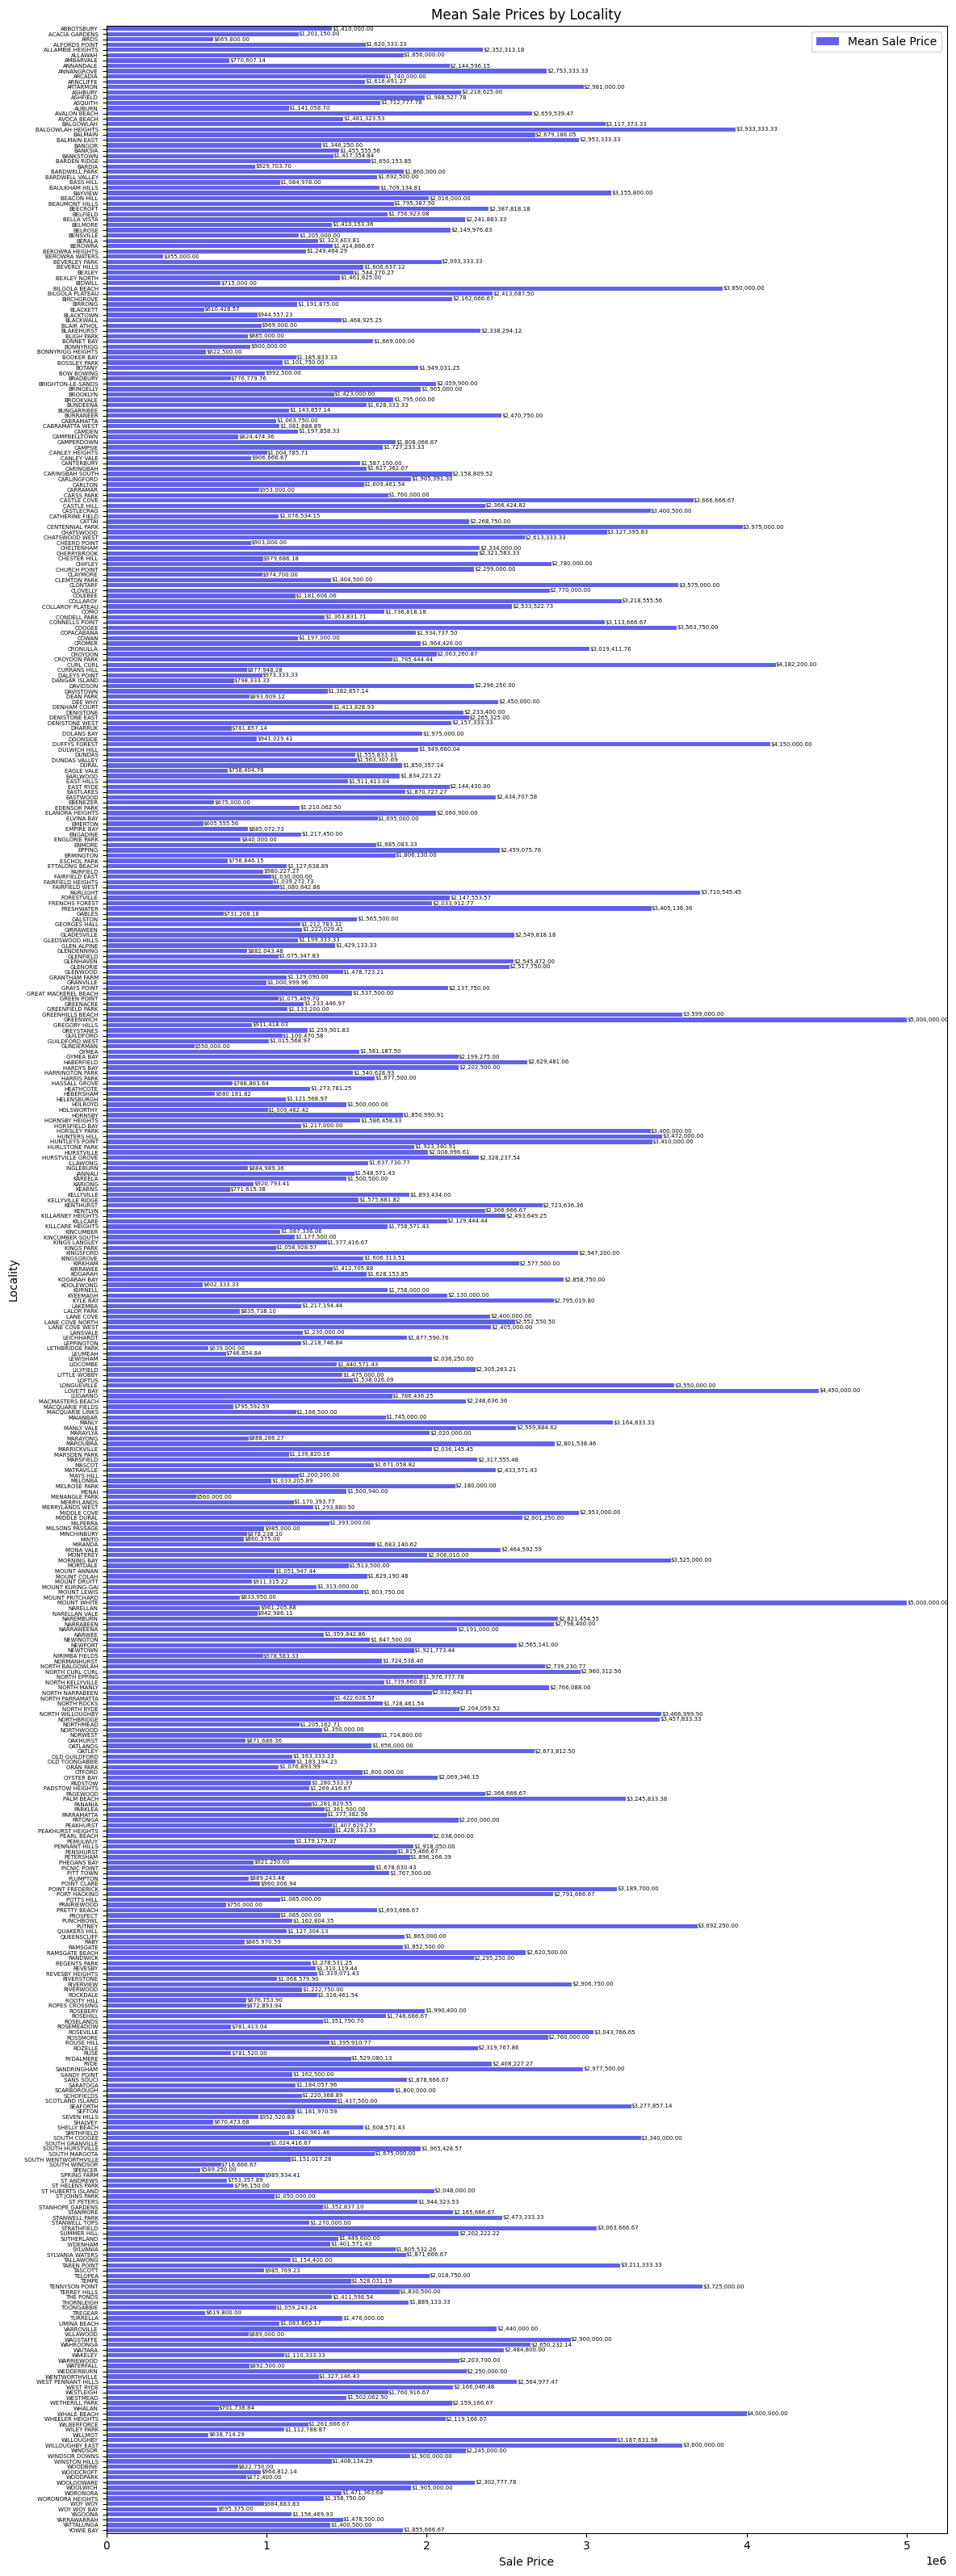

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the plot aesthetics

# Group by 'Locality' and calculate mean and median for 'Sale Price'
locality_stats = df_filtered.groupby('Locality')['Sale Price'].agg(['mean', 'median']).reset_index()

# Plotting
plt.figure(figsize=(12, 32))
bar_plot_mean = sns.barplot(x='mean', y='Locality', data=locality_stats, label='Mean Sale Price', color='blue', alpha=0.7)

plt.title('Mean Sale Prices by Locality')
plt.xlabel('Sale Price')
plt.ylabel('Locality')

# Rotate y-axis labels vertically and adjust font size
plt.yticks(rotation=0, fontsize=5)

# Annotate each bar with its mean sale price formatted as currency
for bar, mean_price in zip(bar_plot_mean.patches, locality_stats['mean']):
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height() / 2, '${:,.2f}'.format(mean_price), ha='left', va='center', fontsize=5)

plt.legend()
plt.tight_layout()
plt.show()


Now to further filter localities below 800k (around my max willingness to spend on an investment home)

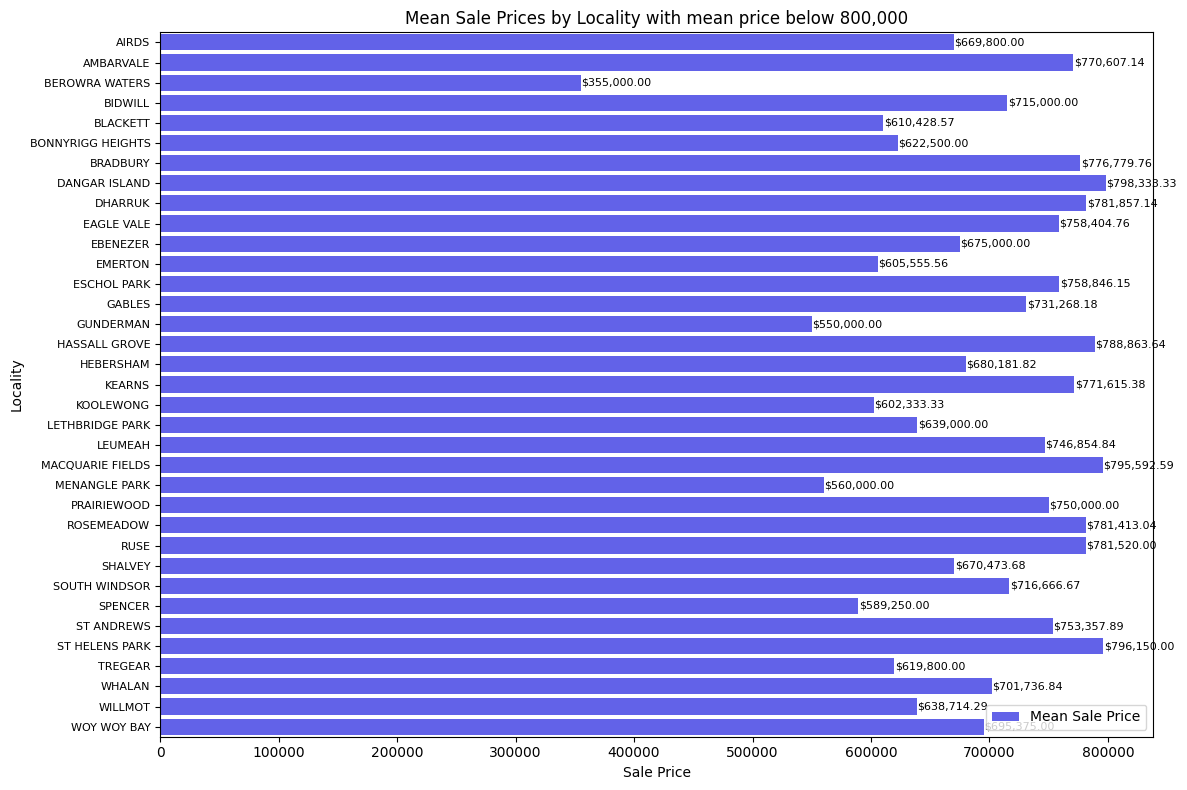

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the plot aesthetics

# Group by 'Locality' and calculate mean and median for 'Sale Price'
locality_stats = df_filtered.groupby('Locality')['Sale Price'].agg(['mean', 'median']).reset_index()

# Filter localities with mean price below 800,000
locality_stats = locality_stats[locality_stats['mean'] <= 800000]

# Plotting
plt.figure(figsize=(12, 8))
bar_plot_mean = sns.barplot(x='mean', y='Locality', data=locality_stats, label='Mean Sale Price', color='blue', alpha=0.7)

plt.title('Mean Sale Prices by Locality with mean price below 800,000')
plt.xlabel('Sale Price')
plt.ylabel('Locality')

# Rotate y-axis labels vertically and adjust font size
plt.yticks(rotation=0, fontsize=8)

# Annotate each bar with its mean sale price formatted as currency
for bar, mean_price in zip(bar_plot_mean.patches, locality_stats['mean']):
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height() / 2, '${:,.2f}'.format(mean_price), ha='left', va='center', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()
